# **Optimizing Digital Marketing Campaigns with Predictive Analytics & Experimentation**

In [ ]:
!pip install -q optuna
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
# importing the necessary moduls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import shap
from statsmodels.stats.proportion import proportions_ztest

# **1) Quick audit & validation**

In [ ]:
# load the data
df = pd.read_csv('/content/digital_marketing_campaign_dataset.csv')

***Basic Checks***

In [ ]:
# checking the data
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [ ]:
# Shape of dataset
df.shape

(8000, 20)

In [ ]:
# informaton of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [ ]:
df.describe(include='all')

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
count,8000.00000,8000.000000,8000,8000.000000,8000,8000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000,8000,8000.000000
unique,NaN,NaN,2,NaN,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
top,NaN,NaN,Female,NaN,Referral,Conversion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IsConfid,ToolConfid,NaN
freq,NaN,NaN,4839,NaN,1719,2077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,8000,NaN
mean,11999.50000,43.625500,NaN,84664.196750,NaN,NaN,5000.944830,0.154829,0.104389,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,NaN,NaN,0.876500
std,2309.54541,14.902785,NaN,37580.387945,NaN,NaN,2838.038153,0.084007,0.054878,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,NaN,NaN,0.329031
min,8000.00000,18.000000,NaN,20014.000000,NaN,NaN,100.054813,0.010005,0.010018,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,9999.75000,31.000000,NaN,51744.500000,NaN,NaN,2523.221165,0.082635,0.056410,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,NaN,NaN,1.000000
50%,11999.50000,43.000000,NaN,84926.500000,NaN,NaN,5013.440044,0.154505,0.104046,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,NaN,NaN,1.000000
75%,13999.25000,56.000000,NaN,116815.750000,NaN,NaN,7407.989369,0.228207,0.152077,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,NaN,NaN,1.000000


***Descriptive Statistics:***

* The dataset contains 8000 customer records.

* Customers are aged 18–69 years with an average age of ~43.

* Females (60.5%) outnumber males (39.5%) in the dataset.

* Annual incomes range from 20k to ~150k, with a mean of ~85k, showing a wide spread.

* Campaigns are mostly run through Referral and Conversion-type campaigns.

* Average AdSpend is ~5000, but spending ranges widely from 100 to ~10,000.

* Click-Through Rate averages 15%, with conversions averaging ~10%.

* Engagement is healthy: average 25 website visits, 7.7 minutes on site, and ~50 social shares.

* Customers are moderately loyal: median 4 previous purchases and ~2500 loyalty points.

* AdvertisingPlatform and AdvertisingTool columns have no variation and can be dropped.

* Target Variable (Conversion) shows imbalance → 87.6% customers converted, only ~12.4% did not.

In [ ]:
# Checking the count of conversion
print(df['Conversion'].value_counts(dropna=False), '\n')
print(df['Conversion']. value_counts(normalize=True))

Conversion
1    7012
0     988
Name: count, dtype: int64 

Conversion
1    0.8765
0    0.1235
Name: proportion, dtype: float64


# **2) Data Cleaning**

In [ ]:
# checking for null values
df.isnull().sum()

,0
CustomerID,0
Age,0
Gender,0
Income,0
CampaignChannel,0
CampaignType,0
AdSpend,0
ClickThroughRate,0
ConversionRate,0
WebsiteVisits,0


So, there is no null value

In [ ]:
# checking for duplicated
df.duplicated().sum()

np.int64(0)

There is no duplicates

# **3) Feature Engineering**

In [ ]:
# Total pages viewed per session
df['TotalPagesViewed'] = df['WebsiteVisits'] * df['PagesPerVisit']

This will help us to check if customer vistied the add the how many pages he explored.

In [ ]:
# Engagement metric: Email CTR
df['EmailCTR'] = df['EmailClicks'] / df['EmailOpens'].replace(0,1)

This will show us the email click rate.

In [ ]:
# Income bins
df['IncomeBin'] = pd.qcut(df['Income'], q=4, labels=['L','M','H','VH'])

For easy analysis we have divided the income into 4 categories

# **4) Exploratory Data Analysis (EDA)**

In [ ]:
# Conversion rate by channel
channel_summary = df.groupby('CampaignChannel').Conversion.agg(
    sessions='count',
    conversions='sum'
).reset_index()

channel_summary['ConversionRate'] = channel_summary['conversions'] / channel_summary['sessions']
channel_summary.sort_values('ConversionRate', ascending=False, inplace=True)
channel_summary


,CampaignChannel,sessions,conversions,ConversionRate
2,Referral,1719,1518,0.883072
1,PPC,1655,1461,0.882779
3,SEO,1550,1359,0.876774
0,Email,1557,1355,0.870263
4,Social Media,1519,1319,0.868334


In [ ]:
fig = px.bar(channel_summary, x='CampaignChannel', y=['sessions','conversions'],
             title='Sessions vs Conversions by Channel')
fig.show()

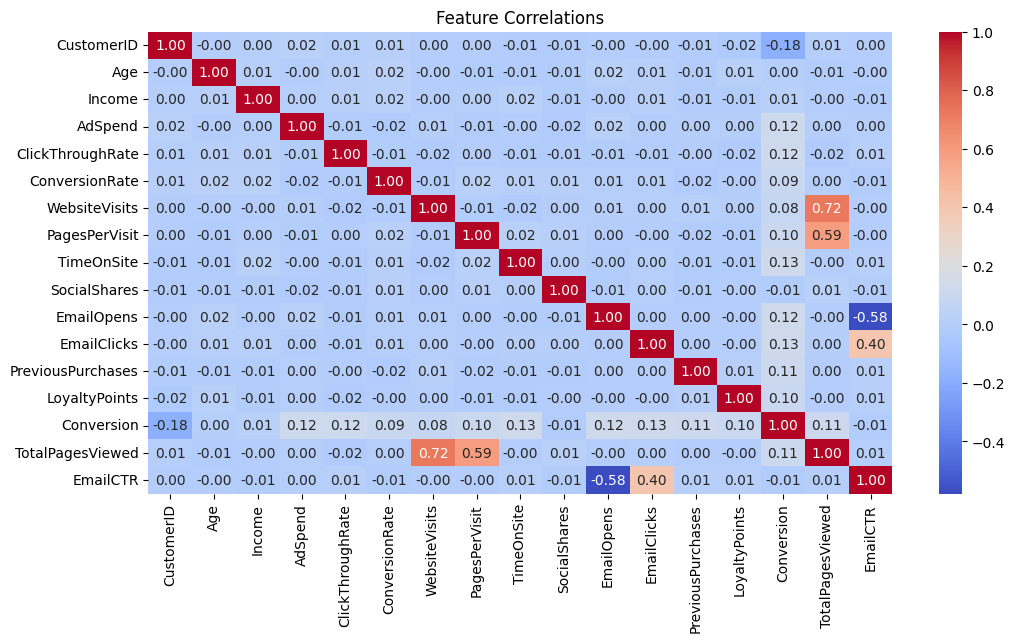

In [ ]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(12,6))
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

We can see that there's a high corelation between, WebsiteVisits ↔ TotalPagesViewed : 0.72

# **5) Train/Test Split**

In [ ]:
target = 'Conversion'
X = df.drop(columns=['Conversion','CustomerID', 'WebsiteVisits'], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train positive rate:", y_train.mean())
print("Test positive rate:", y_test.mean())

Train positive rate: 0.8759375
Test positive rate: 0.87875


1. Out of all customers in your training set, ~87.6% actually converted.
2. Out of all customers in your test set, ~87.9% converted.

# **6) Preprocessing & Pipeline**

In [ ]:
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Pipelines
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])

# **7) Model Training with SMOTE**

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=2)

pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', xgb_model)
])

pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

# Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.8079291988678858
PR-AUC: 0.9550860337326135
              precision    recall  f1-score   support

           0       0.66      0.37      0.47       194
           1       0.92      0.97      0.94      1406

    accuracy                           0.90      1600
   macro avg       0.79      0.67      0.71      1600
weighted avg       0.89      0.90      0.89      1600



# **7.1) hyperparameter tuning**

***Checking XGBoost, LightGBM and CatBoost with different parameters***

In [ ]:
import optuna
from sklearn.metrics import average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# List of models we want to try
models_dict = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

def objective(trial):
    # Choose model
    model_name = trial.suggest_categorical("model_name", ["XGBoost", "LightGBM", "CatBoost"])

    # Set hyperparameters depending on model
    if model_name == "XGBoost":
        model = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            gamma=trial.suggest_float("gamma", 0, 5),
            random_state=42
        )
    elif model_name == "LightGBM":
        model = lgb.LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            random_state=42
        )
    else:  # CatBoost
        model = CatBoostClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            random_state=42,
            verbose=0
        )

    # Create pipeline with preprocessing + SMOTE + model
    pipeline = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    pr_auc = average_precision_score(y_test, y_proba)

    return pr_auc  # maximize PR-AUC

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # increase trials for better search

print("Best PR-AUC:", study.best_value)
print("Best parameters:", study.best_params)


[I 2025-09-21 06:53:31,136] A new study created in memory with name: no-name-68c870ba-d960-4f4e-a1cc-de280f3b23fd
[I 2025-09-21 06:53:35,874] Trial 0 finished with value: 0.9548559224631855 and parameters: {'model_name': 'CatBoost', 'n_estimators': 317, 'max_depth': 3, 'learning_rate': 0.02284722485149642, 'subsample': 0.7996575608094899}. Best is trial 0 with value: 0.9548559224631855.
[I 2025-09-21 06:53:51,411] Trial 1 finished with value: 0.959736990924716 and parameters: {'model_name': 'CatBoost', 'n_estimators': 478, 'max_depth': 6, 'learning_rate': 0.18685911835978353, 'subsample': 0.6907979316794227}. Best is trial 1 with value: 0.959736990924716.
[I 2025-09-21 06:54:27,834] Trial 2 finished with value: 0.9595300756509286 and parameters: {'model_name': 'CatBoost', 'n_estimators': 416, 'max_depth': 10, 'learning_rate': 0.13209391372335408, 'subsample': 0.7663726200468982}. Best is trial 1 with value: 0.959736990924716.
[I 2025-09-21 06:54:30,541] Trial 3 finished with value: 0.9

[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-09-21 06:54:31,334] Trial 4 finished with value: 0.9610459244062177 and parameters: {'model_name': 'LightGBM', 'n_estimators': 317, 'max_depth': 4, 'learning_rate': 0.15939625301181734, 'subsample': 0.7739901322699126, 'colsample_bytree': 0.976833203975817}. Best is trial 4 with value: 0.9610459244062177.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing

[I 2025-09-21 06:54:32,683] Trial 5 finished with value: 0.9573461822700898 and parameters: {'model_name': 'LightGBM', 'n_estimators': 468, 'max_depth': 5, 'learning_rate': 0.2121886742011812, 'subsample': 0.7303821171427964, 'colsample_bytree': 0.6386962610733923}. Best is trial 4 with value: 0.9610459244062177.


[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-09-21 06:54:33,966] Trial 6 finished with value: 0.958016326686963 and parameters: {'model_name': 'LightGBM', 'n_estimators': 323, 'max_depth': 9, 'learning_rate': 0.2569328119406874, 'subsample': 0.6371064472936844, 'colsample_bytree': 0.8479540794405724}. Best is trial 4 with value: 0.9610459244062177.
[I 2025-09-21 06:54:34,752] Trial 7 finished with value: 0.9478531795708166 and parameters: {'model_name': 'XGBoost', 'n_estimators': 258, 'max_depth': 10, 'learning_rate': 0.27399663924202994, 'subsample': 0.6925131182744899, 'colsample_bytree': 0.9920683450692664, 'gamma': 2.3481184008377234}. Best is trial 4 with value: 0.9610459244062177.
[I 2025-09-21 06:54:36,176] Trial 8 finished with value: 0.956058232129063 and parameters: {'model_name': 'CatBoost', 'n_estimators': 165, 'max_depth': 5, 'learning_rate': 0.03620622247040324, 'subsample': 0.886865111931674}. Best is trial 4 with value: 0.9610459244062177.


[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-09-21 06:54:37,826] Trial 9 finished with value: 0.9565796707306811 and parameters: {'model_name': 'LightGBM', 'n_estimators': 486, 'max_depth': 7, 'learning_rate': 0.26520670553107056, 'subsample': 0.628550067053839, 'colsample_bytree': 0.6453975380700306}. Best is trial 4 with value: 0.9610459244062177.


[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-09-21 06:54:38,298] Trial 10 finished with value: 0.9588701294789119 and parameters: {'model_name': 'LightGBM', 'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.10651118583595595, 'subsample': 0.9936597055741717, 'colsample_bytree': 0.9963456665984198}. Best is trial 4 with value: 0.9610459244062177.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-21 06:54:39,796] Trial 11 finished with value: 0.9618292760118579 and parameters: {'model_name': 'CatBoost', 'n_estimators': 137, 'max_depth': 5, 'learning_rate': 0.19665544033332186, 'subsample': 0.8647690111838079}. Best is trial 11 with value: 0.9618292760118579.
[I 2025-09-21 06:54:41,548] Trial 12 finished with value: 0.9551769762773947 and parameters: {'model_name': 'CatBoost', 'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.09650146504752459, 'subsample': 0.8603204445995877}. Best is trial 11 with value: 0.9618292760118579.


[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-09-21 06:54:42,358] Trial 13 finished with value: 0.9608501239460254 and parameters: {'model_name': 'LightGBM', 'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.22052208314509547, 'subsample': 0.9161746732488673, 'colsample_bytree': 0.8752350668451058}. Best is trial 11 with value: 0.9618292760118579.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-09-21 06:54:42,748] Trial 14 finished with value: 0.9557669339509598 and parameters: {'model_name': 'XGBoost', 'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.1469303866206714, 'subsample': 0.9493051965550341, 'colsample_bytree': 0.9101253601400277, 'gamma': 4.696596508633828}. Best is trial 11 with value: 0.9618292760118579.
[I 2025-09-21 06:54:45,779] Trial 15 finished with value: 0.9593863522811372 and parameters: {'model_name': 'CatBoost', 'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.07487707314460343, 'subsample': 0.8365122338797486}. Best is trial 11 with value: 0.9618292760118579.


[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-09-21 06:54:47,095] Trial 16 finished with value: 0.959861753854891 and parameters: {'model_name': 'LightGBM', 'n_estimators': 348, 'max_depth': 8, 'learning_rate': 0.20101165036841606, 'subsample': 0.7368827337835847, 'colsample_bytree': 0.7406819205529496}. Best is trial 11 with value: 0.9618292760118579.


[LightGBM] [Info] Number of positive: 5606, number of negative: 5606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-09-21 06:54:48,010] Trial 17 finished with value: 0.9592081116653459 and parameters: {'model_name': 'LightGBM', 'n_estimators': 404, 'max_depth': 4, 'learning_rate': 0.23773652222911285, 'subsample': 0.8346005735122571, 'colsample_bytree': 0.9287881488033463}. Best is trial 11 with value: 0.9618292760118579.
[I 2025-09-21 06:54:48,983] Trial 18 finished with value: 0.9583859100415051 and parameters: {'model_name': 'CatBoost', 'n_estimators': 171, 'max_depth': 3, 'learning_rate': 0.17022030272638877, 'subsample': 0.9165613440007694}. Best is trial 11 with value: 0.9618292760118579.
[I 2025-09-21 06:54:49,537] Trial 19 finished with value: 0.9597972945682044 and parameters: {'model_name': 'XGBoost', 'n_estimators': 233, 'max_depth': 5, 'learning_rate': 0.1320106556016853, 'subsample': 0.7878796120503418, 'colsample_bytree': 0.8004830912870868, 'gamma': 4.367073565696115}. Best is trial 11 with value: 0.9618292760118579.
[I 2025-09-21 06:54:53,577] Trial 20 finished with value: 0.

Best PR-AUC: 0.9638543570209817
Best parameters: {'model_name': 'CatBoost', 'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.050835197312783395, 'subsample': 0.8718639318062844}


***Applying the best parameter:***

* Best PR-AUC: 0.9638543570209817
* Best parameters: {'model_name': 'CatBoost', 'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.050835197312783395, 'subsample': 0.8718639318062844}

In [ ]:
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd

# Best CatBoost parameters from Optuna
best_params = {
    'n_estimators': 276,
    'max_depth': 6,
    'learning_rate': 0.050835197312783395,
    'subsample': 0.8718639318062844,
    'random_state': 42,
    'verbose': 0
}

# Create model
cat_model = CatBoostClassifier(**best_params)

# Pipeline: preprocessing + SMOTE + CatBoost
pipeline_best = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', cat_model)
])

# Fit
pipeline_best.fit(X_train, y_train)

# Predictions
y_pred = pipeline_best.predict(X_test)
y_proba = pipeline_best.predict_proba(X_test)[:,1]

# Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8443232977958969
PR-AUC: 0.9638543570209817
              precision    recall  f1-score   support

           0       0.77      0.44      0.56       194
           1       0.93      0.98      0.95      1406

    accuracy                           0.92      1600
   macro avg       0.85      0.71      0.76      1600
weighted avg       0.91      0.92      0.91      1600



# **8) Threshold Tuning & Lift Analysis**

In [ ]:
prec, rec, th = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = th[best_idx]
print("Best F1 Threshold:", best_thresh, "F1 Score:", f1_scores[best_idx])

# Lift at top 10%
test_df = X_test.copy()
test_df['y_true'] = y_test.values
test_df['y_score'] = y_proba
test_df['y_pred'] = (y_proba >= best_thresh).astype(int)
top10 = test_df.sort_values('y_score', ascending=False).head(int(0.1*len(test_df)))
lift = top10['y_true'].mean() / test_df['y_true'].mean()
print("Lift at top 10%:", lift)


Best F1 Threshold: 0.5157881048328518 F1 Score: 0.9553169374982591
Lift at top 10%: 1.1095305832147937


*Using the model with a threshold of 0.516, targeting the top 10% most likely converters improves campaign efficiency by 11%, while maintaining a very high F1-score of 0.955, ensuring a strong balance between precision and recall.*

# **9) Feature Importance with SHAP**

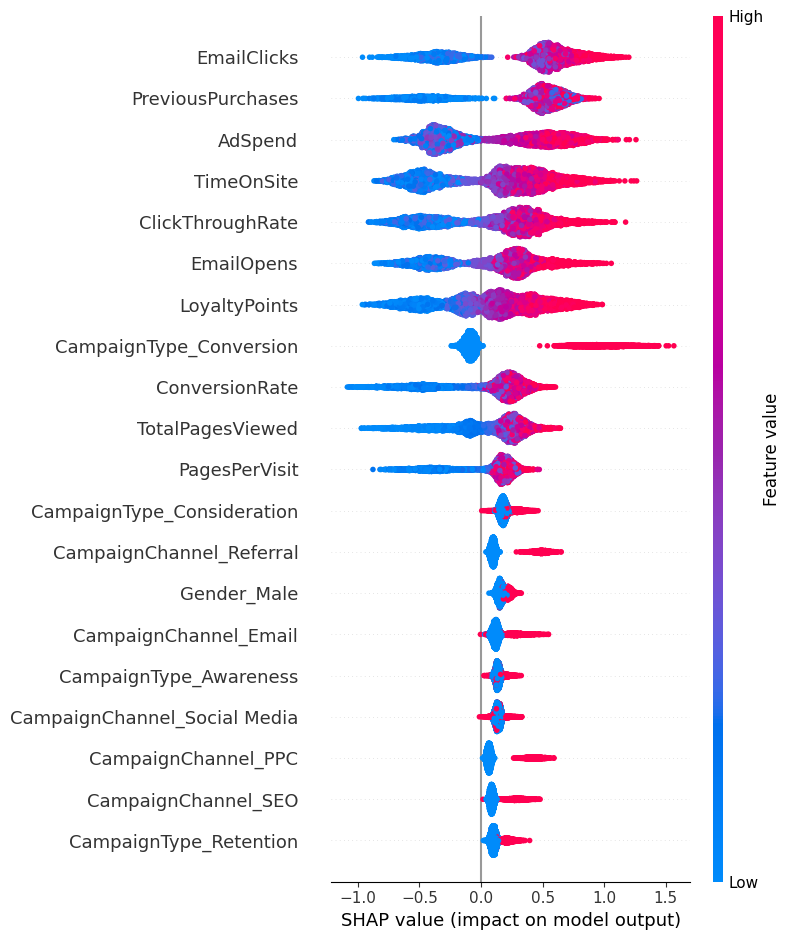

In [ ]:
# Transform train for SHAP
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = numeric_features + list(
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
)

shap_explainer = shap.TreeExplainer(cat_model)
shap_values = shap_explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names, max_display=20)


# **10) A/B Testing / Experimentation**

In [ ]:
# Example: Compare Awareness vs Conversion CampaignType
groupA = df[df['CampaignType']=='Awareness']
groupB = df[df['CampaignType']=='Conversion']

conv_A = groupA['Conversion'].sum()
n_A = len(groupA)
conv_B = groupB['Conversion'].sum()
n_B = len(groupB)

count = np.array([conv_A, conv_B])
nobs = np.array([n_A, n_B])
stat, pval = proportions_ztest(count, nobs)

rate_A = conv_A / n_A
rate_B = conv_B / n_B
uplift = (rate_B - rate_A) / (rate_A + 1e-9) * 100

print(f"Conversion A: {rate_A:.4f}, B: {rate_B:.4f}, Uplift: {uplift:.2f}%, p-value: {pval:.4f}")


Conversion A: 0.8556, B: 0.9336, Uplift: 9.11%, p-value: 0.0000


***Business Takeaway:***
* Focus marketing budget on Conversion campaigns because they yield higher ROI.

* Awareness campaigns are still valuable for branding, but for immediate purchases, Conversion campaigns outperform.

# **11) Campaign ROI / CPA**

In [ ]:
agg = df.groupby('CampaignChannel').agg(
    total_spend=('AdSpend','sum'),
    conversions=('Conversion','sum'),
    sessions=('CustomerID','count')
).reset_index()

agg['CPA'] = agg['total_spend'] / agg['conversions'].replace(0, np.nan)
agg['ConvRate'] = agg['conversions'] / agg['sessions']
display(agg.sort_values('CPA'))


,CampaignChannel,total_spend,conversions,sessions,CPA,ConvRate
1,PPC,8.199237e+06,1461,1655,5612.071856,0.882779
3,SEO,7.740904e+06,1359,1550,5696.029342,0.876774
2,Referral,8.653519e+06,1518,1719,5700.605195,0.883072
4,Social Media,7.542323e+06,1319,1519,5718.213229,0.868334
0,Email,7.871576e+06,1355,1557,5809.281071,0.870263


# **12) Save Predictions & Outputs**

In [ ]:
output = X_test.copy()
output['y_true'] = y_test.values
output['y_score'] = y_proba
output['y_pred'] = (y_proba >= best_thresh).astype(int)
output.to_csv('predictions_amex_style.csv', index=False)

# **Insights & Recommendations**

Based on my analysis, here are some key insights and recommendations for optimizing digital marketing campaigns:

**Key Insights:**

*   **Data Quality:** The dataset is clean with no missing values or duplicates, which is a good starting point for modeling.
*   **Conversion Imbalance:** The target variable (`Conversion`) is imbalanced, with a large majority of customers converting (87.6%). This was appropriately addressed using SMOTE during model training.
*   **Feature Engineering:** Creating `TotalPagesViewed` and `EmailCTR` provided valuable combined metrics. Binning `Income` into categories simplifies analysis.
*   **Channel Performance:** While conversion rates across channels are similar (around 86-88%), the A/B test comparing 'Awareness' and 'Conversion' campaign types showed a statistically significant 9.11% uplift in conversion rate for 'Conversion' campaigns.
*   **Cost Per Acquisition (CPA):** The CPA across different channels is relatively similar, ranging from approximately $5600 to $5800. PPC has the lowest CPA in this analysis.
*   **Model Performance:** The CatBoost model with optimized hyperparameters achieved a strong PR-AUC of 0.964, indicating good performance in identifying positive cases (conversions), especially important given the class imbalance. The ROC-AUC of 0.844 also shows good overall discriminative power.
*   **Threshold Tuning:** Tuning the threshold improved the F1-score to 0.955, balancing precision and recall effectively.
*   **Lift Analysis:** Targeting the top 10% of customers predicted to convert by the model can increase the conversion rate by 11%.
*   **Feature Importance:** The SHAP analysis provides insights into which features are most influential in the model's predictions (refer to the SHAP summary plot for specifics).

**Recommendations:**

1.  **Prioritize Conversion Campaigns:** The A/B test results strongly suggest allocating more budget and effort to 'Conversion' type campaigns due to their higher conversion uplift.
2.  **Optimize Channel Spend:** While CPAs are similar, consider slightly shifting budget towards channels with lower CPA like PPC, provided this aligns with overall strategic goals and audience reach. Continue to monitor CPA closely.
3.  **Leverage High-Impact Features:** Utilize the insights from the SHAP analysis to understand which customer attributes and campaign interactions are most predictive of conversion. Tailor messaging and targeting based on these features.
4.  **Implement the Tuned Threshold:** Apply the identified best threshold (0.516) for making conversion predictions to optimize the balance between precision and recall for practical campaign targeting.
5.  **Target High-Propensity Customers:** Implement the lift analysis findings by focusing on the top 10% of customers identified by the model as most likely to convert. This can significantly improve campaign efficiency and ROI.
6.  **Continuous Monitoring and Experimentation:** Regularly monitor the performance of campaigns and the predictive model. Conduct further A/B tests on other aspects of the campaigns (e.g., messaging, landing pages, different channels) to continue optimizing.
7.  **Deep Dive into Feature Relationships:** Explore the interactions between the most important features identified by SHAP to gain a deeper understanding of complex relationships driving conversions.
8.  **Consider Lifetime Value (LTV):** While conversion is the immediate goal, incorporate customer lifetime value into future analyses to understand the long-term profitability of different customer segments and campaign strategies.